# Real SVM from scratch

In [193]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt

## Kernels
Linear Kernel:

$$\langle x, x'\rangle$$

Polynomial Kernel:

$$(\gamma \langle x, x'\rangle + r)^d$$

Gaussian Kernel:
$${\displaystyle \exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)}$$

Sigmoid tanh Kernel:

$$\tanh(\gamma \langle x,x'\rangle + r)$$

In [194]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p = 3):
    return (1 + np.dot(x1, x2)) ** p

def gaussian_kernel(x1, x2, sigma = 5):
    return np.exp(-np.linalg.norm(x1 - x2)** 2/(2*sigma)**2)

gaussian_kernel(np.array([1,2,3]),np.array([2,3,1]))

0.9417645335842487

## Build SVM class

$$
\begin{aligned}
\mathbf{w} &=\sum_{n=1}^{N} a_{n} t_{n} \phi\left(\mathbf{x}_{n}\right) \\
0 &=\sum_{n=1}^{N} a_{n} t_{n}
\end{aligned}
$$
$$
y(\mathbf{x})=\sum_{n=1}^{N} a_{n} t_{n} k\left(\mathbf{x}, \mathbf{x}_{n}\right)+b .              (7.13)
$$
Having solved the quadratic programming problem and found a value for a, we 
can then determine the value of the threshold parameter b by noting that any support
vector $x_n$ satisfies $t_ny(x_n) = 1$ . Using (7.13) this gives
$$
t_{n}\left(\sum_{m \in \mathcal{S}} a_{m} t_{m} k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+b\right)=1
$$

$$
b=\frac{1}{N_{\mathcal{S}}} \sum_{n \in \mathcal{S}}\left(t_{n}-\sum_{m \in \mathcal{S}} a_{m} t_{m} k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)\right)
$$



In [203]:
class SVM():
    def __init__(self, kernel, C = None):
        self.kernel = kernel
        self.C = C # control soft margin
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = len(y), len(X[0])
        
        # K(Xi,Xj) = kernel(Xi,Xj)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i][j] = self.kernel(X[i],X[j])

        # P = Q(i,j) = y_i*y_j*K(x_i, x_j)
        P = cvxopt.matrix(np.outer(y,y) * K)
        
        # q = -e is the vector of all ones
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        
        # Ax = b <=> y.T*x = 0
        A = cvxopt.matrix(y, (1, n_samples), 'd')

        b = cvxopt.matrix(0.0)
        
        if self.C is None: # Gx < h <=> 0 <= alpha
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else: # Gx < h <=> 0 <= alpha <= C
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.diag(np.ones(n_samples))
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
            
        # Solve Quadratic Programming Problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Lagrange multiplier
        
        alpha = solution['x']
        alpha = np.ravel(alpha)
        sv = alpha > 1e-5 # support vectors => alpha > 0
        sv_idx = np.arange(len(alpha))[sv]
        self.alpha = alpha[sv_idx]
        self.sv = X[sv]
        self.sv_y = y[sv]
        
        # Intercept
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alpha * self.sv_y * K[sv_idx[n],sv])
        self.b /= len(self.alpha)
        
        # This commented lines of code also works 
#         self.b = 0      
#         for enum1, i in enumerate(sv_idx):
#             tmp = 0
#             for enum2, j in enumerate(sv_idx):
#                 tmp+= self.alpha[enum2] * self.sv_y[enum2] * K[i,j]
#             self.b += self.sv_y[enum1] - tmp
#         self.b /= len(sv_idx)
        
        # Weights vectors
        
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for a, sv_y, sv_x in zip(self.alpha, self.sv_y, self.sv):
                self.w += a * sv_y * sv_x
        else:
            self.w = None # other using kernel trick to compute prediction
        
        # This commented lines of code also works 
#         if self.kernel == linear_kernel:
#             self.w = np.zeros(n_features)
#             for n in range(len(self.alpha)):
#                 self.w += self.alpha[n] * self.sv_y[n] * self.sv[n]
#         else:
#             self.w = None

    def project(self, X):
        if self.kernel == linear_kernel:
            return np.dot(X, self.w) + self.b
        else:
            preds = np.zeros(len(X))
            for i in range(len(X)):
                predictions = 0 
                for a, sv_y, sv_x in zip(self.alpha, self.sv_y, self.sv):
                    predictions += a * sv_y * self.kernel(X[i],sv_x)
                preds[i] = predictions
            return preds + self.b
        
    def predict(self, X):
        return np.sign(self.project(X))

In [196]:
X_train = np.array([[1,2],[1,3],[2,3],[9,10],[9,8],[10,10]])
y_train = np.array([1,1,1,-1,-1,-1])
svm = SVM(kernel=linear_kernel)
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['maxiters']=100

# print((X_train, y_train)
SVM.fit(svm, X_train, y_train)
svm.predict(X_train)

array([ 1.,  1.,  1., -1., -1., -1.])

In [198]:
svm2 = SVM(kernel=gaussian_kernel)
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['maxiters']=100

# print((X_train, y_train)
SVM.fit(svm2, X_train, y_train)
svm2.predict(X_train)

array([ 1.,  1.,  1., -1., -1., -1.])

Given training vectors $x_i \in \mathbb{R}^p$, i=1,…, n, in two classes, and a vector $y \in \{1, -1\}^n$, our goal is to find $w \in
\mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by $\text{sign} (w^T\phi(x) + b)$ is correct for most samples.
Solve the following primal problem:
$$
\begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align}
$$

Dual problem to the primal is:
$$
\begin{align}\begin{aligned}\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha - e^T \alpha\\\begin{split}
\textrm {subject to } & y^T \alpha = 0\\
& 0 \leq \alpha_i \leq C, i=1, ..., n\end{split}\end{aligned}\end{align}
$$
where, 
* $e$ is the vector of all ones,
* $Q_{ij} \equiv y_i y_j K(x_i, x_j)$ is an $nxn$ positive semidefine(PSD) matrix,
* $K(x_i, x_j) = \phi (x_i)^T \phi (x_j)$ is the kernel,
* $\alpha_i$ is dual coefficients, and they are upper-bounded by $C$.

`note`: $\alpha$ appears when using Lagrange multiplier on primal problem
        
Once the optimization problem is solved, the output of decision_function for a given sample becomes:

$$\sum_{i\in SV} y_i \alpha_i K(x_i, x) + b,$$

The primal problem can be equivalently formulated as:
$$\min_ {w, b} \frac{1}{2} w^T w + C \sum_{i=1}\max(0, y_i (w^T \phi(x_i) + b)),$$
where we make use of **Hinge Loss**.



Dual problem in form of Quadratic Programming:
\begin{align}\begin{aligned}\min_{\alpha} \frac{1}{2} x^T P x + q^T x\\\begin{split}
\textrm {subject to } & Gx \preceq h\\
& Ax = b\end{split}\end{aligned}\end{align}


In [221]:
def plot_margin(X1, X2, clf):
    
    plt.plot(X1[:, 0], X1[:, 1], 'r+')
    plt.plot(X2[:, 0], X2[:, 1], 'bo')
    plt.scatter(clf.sv[:, 0], clf.sv[:, 1], s= 100, c = "g")
    
    def hyperplane(x, w, b, c):
        return (- w[0]*x - b + c) / w[1]
    
    max_val = np.max([X1,X2]) * 1.1
    min_val = np.min([X1,X2]) * .9
    
    # wx+b = 0    
    db1 = hyperplane(min_val, clf.w, clf.b, 0)
    db2 = hyperplane(max_val, clf.w, clf.b, 0)
    plt.plot([min_val, max_val], [db1, db2], 'y--')
    
    # wx+b = 1
    psv1 = hyperplane(min_val, clf.w, clf.b, 1)
    psv2 = hyperplane(max_val, clf.w, clf.b, 1)
    plt.plot([min_val, max_val], [psv1, psv2], 'k')
    
    # wx+b = -1
    nsv1 = hyperplane(min_val, clf.w, clf.b, -1)
    nsv2 = hyperplane(max_val, clf.w, clf.b, -1)
    plt.plot([min_val, max_val], [nsv1, nsv2], 'k')
    
    plt.show()

def plot_contour(X1, X2, clf):
    
    plt.plot(X1[:, 0], X1[:, 1], 'r+')
    plt.plot(X2[:, 0], X2[:, 1], 'bo')
    plt.scatter(clf.sv[:, 0], clf.sv[:, 1], s= 100, c = "g")
    
    max_val = 30 #np.max([X1,X2]) * 1.1
    min_val = -20# np.min([X1,X2]) * .9
    
    x1, x2 = np.meshgrid(np.linspace(min_val, max_val, 100), np.linspace(min_val, max_val, 100))
    X = np.array([[m,n] for m,n in zip(np.ravel(x1), np.ravel(x2))])
    Z = clf.project(X).reshape(x1.shape)
    plt.contour(x1, x2, Z, [0.0], colors='k', linewidths=1, origin='lower' )
    plt.contour(x1, x2, Z + 1, [0.0] , colors='blue', linewidths=1, origin='lower')
    plt.contour(x1, x2, Z - 1, [0.0], colors='red', linewidths=1, origin='lower')
        

In [303]:
def get_sep_linear_data():
    mean1 = [0, 10]
    mean2 = [10, 0]
    cov = [[10,0.8],[0.8, 0.6]]

    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2
def get_sep_non_linear_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    print(X1.shape)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    print(X1.shape)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

(100, 2)


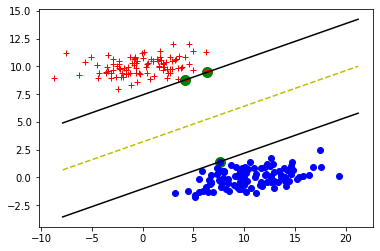

In [304]:
X1, y1, X2, y2 = get_sep_linear_data()
print(X1.shape)

svm2 = SVM(kernel=linear_kernel, )
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['maxiters']=100

# print((X_train, y_train)
SVM.fit(svm2, np.vstack((X1, X2)) , np.hstack((y1, y2)))
svm2.predict(X_train)
#     plot_margin(X_train[y_train ==1], X_train[y_train==-1], svm2)
plot_margin(X1, X2, svm2)

(50, 2)
(100, 2)


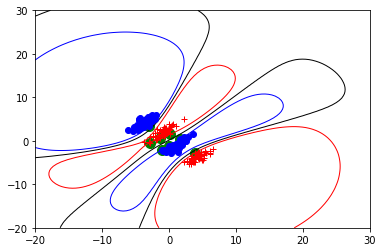

In [308]:
X1, y1, X2, y2 = get_sep_non_linear_data()
# print(X1.shape)

svm2 = SVM(kernel=gaussian_kernel, )
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['maxiters']=100

# print((X_train, y_train)
SVM.fit(svm2, np.vstack((X1, X2)) , np.hstack((y1, y2)))
svm2.predict(X_train)
#     plot_margin(X_train[y_train ==1], X_train[y_train==-1], svm2)
plot_contour(X1, X2, svm2)

## Refs

https://gist.github.com/mblondel/586753

https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation

https://cvxopt.org/userguide/coneprog.html#quadratic-programming